In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [16]:
data = pd.read_csv('DS-Take-Home-Sample-Data - DS-Take-Home-Sample-Data.csv')
data.head()

,source,campaign,region,locality,preferred_doctor_gender,dental_anxiety,last_visited_a_dentist,how_soon_they_want_to_book,reason_for_visit,patient_insured,number_of_match_results,out_network_results_shown,in_network_results_shown,avg_distance_overall,appointment_requested,appointment_status,appointment_scheduled,appointment_billed,chosen_provider_insurance_status,chosen_provider_distance
0,facebook,san_diego_dentist_patient_acquisition,San Jose,San Jose,No Pref,A little nervous,< 1 year,ASAP,Specific Treatment,f,9,0,0,10547.219510,f,NaN,f,NaN,NaN,NaN
1,facebook,san_diego_dentist_patient_acquisition,San Diego,Chula Vista,F,Not at all nervous,2+ years,2 weeks,Checkup & Cleaning,f,2,0,0,20784.617720,f,NaN,f,NaN,NaN,NaN
2,try.opencare.com,Unknown,Austin,Austin,No Pref,Moderately nervous,2+ years,ASAP,Checkup & Cleaning,t,9,8,1,8014.945931,t,CANCELLED,f,f,in-network,2855.594821
3,facebook,denver_dentist_patient_acquisition,Denver,Golden,No Pref,Not at all nervous,< 1 year,ASAP,Specific Treatment,t,8,2,6,16651.158750,f,NaN,f,NaN,NaN,NaN
4,facebook,chicago_dentist_patient_acquisition,Chicago,Chicago,F,Not at all nervous,< 1 year,1 week,Checkup & Cleaning,f,9,0,0,5216.934559,f,NaN,f,NaN,NaN,NaN


In [17]:
success = []
for i in range(len(data)):
    if (data['appointment_requested'][i] == 't') & (data['appointment_scheduled'][i] == 't') & (data['appointment_billed'][i] == 't'):
        success.append(1)
    else:
        success.append(0)

In [18]:
data['success'] = success

In [46]:
other = data[(data.locality != 'Chicago') & (data.locality != 'San Francisco') & (data.locality != 'Seattle')]

In [49]:
other.success.sum()/len(other)

0.07586558044806517

In [48]:
len(other)

7856

In [51]:
other = other.fillna(0)

In [52]:
cat_features = list(other.columns[data.dtypes == 'object'])
cat_features

['source',
 'campaign',
 'region',
 'locality',
 'preferred_doctor_gender',
 'dental_anxiety',
 'last_visited_a_dentist',
 'how_soon_they_want_to_book',
 'reason_for_visit',
 'patient_insured',
 'appointment_requested',
 'appointment_status',
 'appointment_scheduled',
 'appointment_billed',
 'chosen_provider_insurance_status']

In [53]:
cat_dict = {}

for col in cat_features:
    cat_dict[col] = {}
    count = 0
    for label in list(other[col].unique()):
        cat_dict[col][label] = count
        count += 1
    
def convert_cat(col, label):
    return (cat_dict[col][label])

for col in cat_features:
    other[col] = other[col].apply(lambda x: convert_cat(col,x))

In [54]:
X = other[['source', 'campaign', 'region', 'locality', 'preferred_doctor_gender',
       'dental_anxiety', 'last_visited_a_dentist',
       'how_soon_they_want_to_book', 'reason_for_visit', 'patient_insured',
       'number_of_match_results', 'out_network_results_shown',
       'in_network_results_shown', 'avg_distance_overall']]
y = other['success']

In [26]:
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [27]:
# Create function to return the results of machine learning tests
def ml_classification_tests(X, y, num_cols=X.shape[1]):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #------------------------------------------------------------------------
    
    # NAIVE BAYES
    print('Naive Bayes')
    
    #the grid of parameters to search over
    alphas = [0.001, 0.01, .1, 1, 5]
    
    param_grid = {'alpha': alphas}
    
    # Create a multinomial classifier
    mnb = MultinomialNB()
    
    mnb_cv = GridSearchCV(mnb, param_grid, cv=5)
    
    # Fit the classifier to the data
    mnb_cv.fit(X_train, y_train)
    
    # Print the tuned parameters and score
    print("Best Naive Bayes alpha: {}".format(mnb_cv.best_params_)) 
    print("Best Naive Bayes score: {}".format(mnb_cv.best_score_))
    
    # Predict the labels of the test set: y_pred
    y_pred = mnb_cv.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:', classification_report(y_test, y_pred))
    
    #------------------------------------------------------------------------
    
    # RANDOM FORESTS
    print('\nRandom Forests')
    
    # Number of features to consider at every split
    max_features = [1, 2, 3, 4, 5]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4, 6, 9]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}    
    
    # Instantiate a Random Forest Classifier
    rfc = RandomForestClassifier(n_estimators=250)
    
    # Instantiate RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, cv = 5, n_jobs = -1, n_iter=12)
    
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    # Print the tuned parameters and score
    print("Tuned Random Forest Parameters: {}".format(rf_random.best_params_))
    print("Best Random Forest score: {}".format(rf_random.best_score_))
    
    # Predict the labels of the test set: y_pred
    y_pred = rf_random.predict(X_test)

    # Compute and print the confusion matrix and classification report
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))
    print('Classification Report:', classification_report(y_test, y_pred))

    #------------------------------------------------------------------------
    

In [55]:
import imblearn
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)
print(sorted(Counter(y_resampled).items()))

[(0, 7260), (1, 7260)]


In [56]:
ml_classification_tests(X_resampled, y_resampled)

Naive Bayes
Best Naive Bayes alpha: {'alpha': 0.001}
Best Naive Bayes score: 0.5569329660238751
Confusion Matrix: [[ 575 1253]
 [ 338 1464]]
Classification Report:               precision    recall  f1-score   support

           0       0.63      0.31      0.42      1828
           1       0.54      0.81      0.65      1802

   micro avg       0.56      0.56      0.56      3630
   macro avg       0.58      0.56      0.53      3630
weighted avg       0.58      0.56      0.53      3630


Random Forests
Tuned Random Forest Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 1, 'max_depth': 80, 'bootstrap': False}
Best Random Forest score: 0.9884297520661157
Confusion Matrix: [[1802   26]
 [   0 1802]]
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1828
           1       0.99      1.00      0.99      1802

   micro avg       0.99      0.99      0.99      3630
   macro avg       0.99   

In [57]:
names = X.keys()
 
#use linear regression as the model
rfc = RandomForestClassifier(n_estimators=250,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            max_features = 0.5,
                            max_depth = 70,
                            bootstrap = True)
#rank all features, i.e continue the elimination until the last one
rfe = RFE(rfc, n_features_to_select=1)
rfe.fit(X_resampled,y_resampled)
 
print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

Features sorted by their rank:
[(1, 'avg_distance_overall'), (2, 'in_network_results_shown'), (3, 'locality'), (4, 'campaign'), (5, 'out_network_results_shown'), (6, 'how_soon_they_want_to_book'), (7, 'dental_anxiety'), (8, 'source'), (9, 'number_of_match_results'), (10, 'last_visited_a_dentist'), (11, 'region'), (12, 'patient_insured'), (13, 'reason_for_visit'), (14, 'preferred_doctor_gender')]


In [34]:
data.how_soon_they_want_to_book.describe()

count     11923
unique        5
top        ASAP
freq       3833
Name: how_soon_they_want_to_book, dtype: object

In [35]:
chi.how_soon_they_want_to_book.describe()

count    1667.000000
mean        2.194361
std         1.260973
min         0.000000
25%         1.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: how_soon_they_want_to_book, dtype: float64

In [36]:
chii = data[data.locality == 'Chicago']

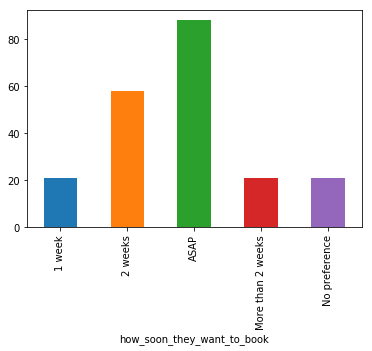

In [44]:
chii.groupby(['how_soon_they_want_to_book'])['success'].sum().plot(kind = 'bar')

In [ ]:
## we know that in Chicago, the most important features are still avg overall distance, 
## and in-network results shown.
## we also know that most successful appointments are those th